In [2]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In [3]:
from pynq.lib import Pmod_ADC, Pmod_DAC
import time
import ctypes
import numpy as np
import array
from pynq import allocate
import numpy as np 

In [4]:
dac = Pmod_DAC(base.PMODB)

In [5]:
def run_transmit():
    # Load transmit data from file
    with open("/home/xilinx/pynq/tx_out.dat", mode='rb') as file:
        file_content = file.read()
    float_strs = file_content.split(b" ")
    
    volt_floats = [float(x) for x in float_strs if x != b'']
    
    max_voltage = max([abs(x) for x in volt_floats])
    
    # shift the voltages so all are positive and scale to 12 bit uint (store as 16 bit uint)
    volt_pos = [x + max_voltage for x in volt_floats]
    #DAC_MAX = 4095
    DAC_MAX = 1638
    volt_scaled = np.asarray([np.uint16(x*(DAC_MAX/(2*max_voltage))) for x in volt_pos])
    #volt_scaled = array.array('i', [np.uint16(x*(DAC_MAX/(2*max_voltage))) for x in volt_pos])

    length = len(volt_scaled)
    py_buffer = allocate(shape=(length,), dtype=np.int32)
    
    for i in range(length):
        py_buffer[i] = volt_scaled[i]
        
    #print("py_buffer physical address {}".format(hex(py_buffer.physical_address)))
    #print(py_buffer[0:10])
    
    #print(dir(volt_scaled.buffer_info()[0]))
    #pointer, read_only_flag = volt_scaled.__array_interface__['data']
    #print(hex(pointer))
    #print((pointer))
    #for i in range(len(volt_scaled)):
    #    print(hex(ctypes.addressof(volt_scaled.buffer_info()[0].contents[i])))
    #    print(volt_scaled[i].data)
    
    #print("writing to dac...")
    #while True:
    
    i = 1
#    while i < 50:
    while True:
        dac.write(py_buffer.physical_address|0x00000003)
        i = i+1
    
    #return py_buffer


In [6]:
run_transmit()

KeyboardInterrupt: 

## Square Wave

In [7]:
def run_transmit_sq():
    # Load transmit data from file
    with open("/home/xilinx/pynq/tx_out.dat", mode='rb') as file:
        file_content = file.read()
    float_strs = file_content.split(b" ")
    
    volt_floats = [float(x) for x in float_strs if x != b'']
    
    max_voltage = max([abs(x) for x in volt_floats])
    
    # shift the voltages so all are positive and scale to 12 bit uint (store as 16 bit uint)
    volt_pos = [x + max_voltage for x in volt_floats]
    #DAC_MAX = 4095
    DAC_MAX = 64
    volt_scaled = np.asarray([np.uint16(x*(DAC_MAX/(2*max_voltage))) for x in volt_pos])
    #volt_scaled = array.array('i', [np.uint16(x*(DAC_MAX/(2*max_voltage))) for x in volt_pos])

    length = len(volt_scaled)
    py_buffer = allocate(shape=(length,), dtype=np.int32)
    
    a = np.zeros((1888))
    b = np.full(1888, 800)

    py_buffer[::2] = a
    py_buffer[1::2] = b

    #for i in range(length):
     #   py_buffer[i] = volt_scaled[i]
        #py_buffer[i] = b[i]
        
    #print("py_buffer physical address {}".format(hex(py_buffer.physical_address)))
    #print(len(volt_scaled))
    #print(py_buffer[0:10])
#    print(volt_scaled[0:10])
    
    #print(dir(volt_scaled.buffer_info()[0]))
    pointer, read_only_flag = volt_scaled.__array_interface__['data']
    #print(hex(pointer))
    #print((pointer))
    #for i in range(len(volt_scaled)):
    #    print(hex(ctypes.addressof(volt_scaled.buffer_info()[0].contents[i])))
    #    print(volt_scaled[i].data)
    
    #print("writing to dac...")
    dac.write(py_buffer.physical_address|0x00000003)
    
    return py_buffer

## Sine Wave ##

In [8]:
def run_transmit_sine():
    length = 31
    py_buffer = allocate(shape=(length,), dtype=np.int32)
    
    a = [32, 48, 55, 60, 64, 60, 55, 48, 32, 20, 15, 10, 5, 10, 15, 20, 32, 48, 55, 60, 64, 60, 55, 48, 32, 20, 15, 10, 5, 10, 15, 20, 32]
    
    for i in range(length):
        py_buffer[i] = a[i]
        
    #print("py_buffer physical address {}".format(hex(py_buffer.physical_address)))
    #print(len(volt_scaled))
    #print(py_buffer[0:10])
#    print(volt_scaled[0:10])
    
        #print("writing to dac...")
    dac.write(py_buffer.physical_address|0x00000003)
    
    return py_buffer

In [9]:
while True:
    run_transmit_sine()   

KeyboardInterrupt: 

In [10]:
i=1
while i<10:
    run_transmit()
    i = i+1

KeyboardInterrupt: 

In [ ]:
while True:
    dac.write(2.0)
    dac.write(0)

<function matplotlib.pyplot.show(close=None, block=None)>

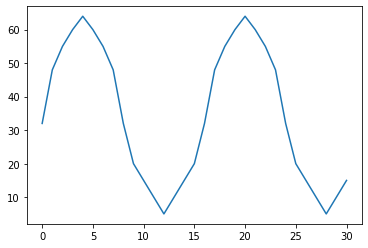

In [11]:
import matplotlib.pyplot as plt 

tx = run_transmit_sine()
plt.plot(tx)
plt.show

In [12]:
import matplotlib.pyplot as plt 

tx = run_transmit()
plt.plot(tx)
plt.show

KeyboardInterrupt: 

# Transmit When Button 0 is Pressed

In [35]:
import asyncio
import pynq.lib.rgbled as rgbled 
led4 = rgbled.RGBLED(4)
btns = base.btns_gpio

In [36]:
class Buttons:    
    none = 0
    BTN0 = 1
    BTN1 = 2
    
noColor = 0x0
blue = 0x1
green = 0x2
red = 0x4
    
numColorChanges = 0
maxColorChanges = 4
lastBtnPressed = Buttons.none
buttonPressed = Buttons.none

checkBtnsSleepTime = 0.01

blinking = True

In [37]:
def lightLed(color):
    global numColorChanges, lastBtnPressed, buttonPressed
    
    if (lastBtnPressed != buttonPressed) and (buttonPressed != Buttons.none):
        led4.write(color)
        numColorChanges += 1
        lastBtnPressed = buttonPressed

In [38]:
async def checkButtons(_loop):
    global numColorChanges, maxColorChanges, lastBtnPressed, buttonPressed, checkBtnsSleepTime
    
    numColorChanges = 0
    maxColorChanges = 4
    lastBtnPressed = Buttons.none
    buttonPressed = Buttons.none

    led4.off()
    base.leds[0].on()
    base.leds[1].on()

    while numColorChanges < maxColorChanges:
        await asyncio.sleep(checkBtnsSleepTime)
        buttonPressed = btns.read()

        match buttonPressed:          
            case Buttons.BTN0:
                lightLed(green)
            case Buttons.BTN1:
                lightLed(red)
                
    led4.off()
    base.leds[0].off()
    base.leds[1].off()
    base.leds[3].off()
    blinking = False
    _loop.stop()

In [39]:
async def transmitClicking():
    global blinking, lastBtnPressed
    blinkSleepTime = 0.01
    
    base.leds[3].off()
    
    while blinking:
        await asyncio.sleep(blinkSleepTime)
        
        if lastBtnPressed == Buttons.BTN0:
            run_transmit_sine()
            
        if lastBtnPressed == Buttons.BTN1:
            dac.write(0)

In [40]:
loop = asyncio.new_event_loop()
loop.create_task(transmitClicking())
loop.create_task(checkButtons(loop))
loop.run_forever()
loop.close()  

print("Finished.\n")

Finished.

